In [18]:
import pandas as pd
import numpy as np  
import os
import joblib
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from utils.data_handler import get_games, compute_head_to_head_avg, get_season_start
df = get_games()

In [20]:
df['home_avg_points'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_avg_points'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df[['home_head_to_head_avg_points', 'away_head_to_head_avg_points']] = df.apply(
    lambda row: compute_head_to_head_avg(row, df), axis=1
)

df['home_last_5_win_percentage'] = (
    df.groupby('home_teamId')['home_win']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_last_5_win_percentage'] = (
    df.groupby('away_teamId')['away_win']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['gameDate'] = pd.to_datetime(df['gameDate'], errors='coerce', utc=True)

df['season'] = df['gameDate'].apply(get_season_start)

df = df.sort_values('gameDate').reset_index(drop=True)

df['home_season_win_percentage'] = (
    df.groupby(['home_teamId', 'season'])['home_win']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['away_season_win_percentage'] = (
    df.groupby(['away_teamId', 'season'])['away_win']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_advantage'] = 1

# Offensive Efficiency (points per possession)
df['home_possessions'] = df['home_fieldGoalsAttempted'] + 0.44 * df['home_freeThrowsAttempted'] + df['home_turnovers']
df['away_possessions'] = df['away_fieldGoalsAttempted'] + 0.44 * df['away_freeThrowsAttempted'] + df['away_turnovers']

df['home_off_efficiency'] = df['home_teamScore'] / df['home_possessions'].replace(0, np.nan)
df['away_off_efficiency'] = df['away_teamScore'] / df['away_possessions'].replace(0, np.nan)

df['home_off_eff_L5'] = (
    df.groupby('home_teamId')['home_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_off_eff_L5'] = (
    df.groupby('away_teamId')['away_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_off_eff_L10'] = (
    df.groupby('home_teamId')['home_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_off_eff_L10'] = (
    df.groupby('away_teamId')['away_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

# Defensive Efficiency (points allowed)
df['home_def_efficiency'] = (
    df.groupby('home_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_def_efficiency'] = (
    df.groupby('away_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

# Pace (possessions per game)
df['game_pace'] = (df['home_possessions'] + df['away_possessions']) / 2
df['home_pace_L5'] = (
    df.groupby('home_teamId')['game_pace']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_pace_L5'] = (
    df.groupby('away_teamId')['game_pace']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_pace'] = (
    df['home_fieldGoalsAttempted'] + df['home_turnovers'] + 0.44 * df['home_freeThrowsAttempted']
)
df['away_pace'] = (
    df['away_fieldGoalsAttempted'] + df['away_turnovers'] + 0.44 * df['away_freeThrowsAttempted']
)

df['home_pace_avg'] = (
    df.groupby('home_teamId')['home_pace']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_pace_avg'] = (
    df.groupby('away_teamId')['away_pace']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['pace_sum'] = df['home_pace_avg'] + df['away_pace_avg']

df['home_eFG'] = (df['home_fieldGoalsMade'] + 0.5 * df['home_threePointersMade']) / df['home_fieldGoalsAttempted'].replace(0, np.nan)
df['away_eFG'] = (df['away_fieldGoalsMade'] + 0.5 * df['away_threePointersMade']) / df['away_fieldGoalsAttempted'].replace(0, np.nan)

df['home_eFG_L5'] = (
    df.groupby('home_teamId')['home_eFG']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_eFG_L5'] = (
    df.groupby('away_teamId')['away_eFG']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_eFG_L10'] = (
    df.groupby('home_teamId')['home_eFG']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_eFG_L10'] = (
    df.groupby('away_teamId')['away_eFG']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

# Three-Point Shooting
df['home_3p_made_L5'] = (
    df.groupby('home_teamId')['home_threePointersMade']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_3p_made_L5'] = (
    df.groupby('away_teamId')['away_threePointersMade']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_reb_L5'] = (
    df.groupby('home_teamId')['home_reboundsTotal']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_reb_L5'] = (
    df.groupby('away_teamId')['away_reboundsTotal']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_oreb_rate'] = df['home_reboundsOffensive'] / (df['home_reboundsOffensive'] + df['away_reboundsDefensive']).replace(0, np.nan)
df['away_oreb_rate'] = df['away_reboundsOffensive'] / (df['away_reboundsOffensive'] + df['home_reboundsDefensive']).replace(0, np.nan)

df['home_oreb_rate_L5'] = (
    df.groupby('home_teamId')['home_oreb_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_oreb_rate_L5'] = (
    df.groupby('away_teamId')['away_oreb_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_to_L5'] = (
    df.groupby('home_teamId')['home_turnovers']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_to_L5'] = (
    df.groupby('away_teamId')['away_turnovers']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_ast_L5'] = (
    df.groupby('home_teamId')['home_assists']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_ast_L5'] = (
    df.groupby('away_teamId')['away_assists']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

# Points in Paint
df['home_paint_L5'] = (
    df.groupby('home_teamId')['home_pointsInThePaint']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_paint_L5'] = (
    df.groupby('away_teamId')['away_pointsInThePaint']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_fastbreak_L5'] = (
    df.groupby('home_teamId')['home_pointsFastBreak']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_fastbreak_L5'] = (
    df.groupby('away_teamId')['away_pointsFastBreak']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_pts_L3'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
)
df['away_pts_L3'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
)

df['home_pts_L5'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_pts_L5'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_pts_L10'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_pts_L10'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

df['home_pts_std_L10'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=3).std())
)
df['away_pts_std_L10'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=3).std())
)

df['home_home_pts_avg'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_away_pts_avg'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_trend_10'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(10, 2).apply(lambda x: x.iloc[-1] - x.iloc[0]))
)

df['away_trend_10'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(10, 2).apply(lambda x: x.iloc[-1] - x.iloc[0]))
)

df['home_allowed_avg'] = (
    df.groupby('home_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_allowed_avg'] = (
    df.groupby('away_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_win_pct_L10'] = (
    df.groupby('home_teamId')['home_win']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_win_pct_L10'] = (
    df.groupby('away_teamId')['away_win']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

df['expected_total_score'] = df['home_pts_L10'] + df['away_pts_L10']
df['expected_home_vs_away_def'] = df['home_off_eff_L10'] * df['away_def_efficiency']
df['expected_away_vs_home_def'] = df['away_off_eff_L10'] * df['home_def_efficiency']

df['home_off_season'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_off_season'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_def_season'] = (
    df.groupby('home_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_def_season'] = (
    df.groupby('away_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['expected_total_pre'] = (
    0.5 * (df['home_off_season'] + df['away_off_season']) -
    0.3 * (df['home_def_season'] + df['away_def_season']) +
    0.1 * df['pace_sum']
)

df['pace_differential'] = df['home_pace_L5'] - df['away_pace_L5']

df['off_eff_differential'] = df['home_off_eff_L10'] - df['away_off_eff_L10']
df['def_eff_differential'] = df['home_def_efficiency'] - df['away_def_efficiency']

df['eFG_differential'] = df['home_eFG_L10'] - df['away_eFG_L10']

df['home_momentum'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=2).apply(
        lambda vals: vals.iloc[-1] - vals.iloc[0] if len(vals) >= 2 else 0
    ))
)
df['away_momentum'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=2).apply(
        lambda vals: vals.iloc[-1] - vals.iloc[0] if len(vals) >= 2 else 0
    ))
)

df['home_pts_weighted'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)
df['away_pts_weighted'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)

df['home_TS'] = df['home_teamScore'] / (2 * (df['home_fieldGoalsAttempted'] + 0.44 * df['home_freeThrowsAttempted'])).replace(0, np.nan)
df['away_TS'] = df['away_teamScore'] / (2 * (df['away_fieldGoalsAttempted'] + 0.44 * df['away_freeThrowsAttempted'])).replace(0, np.nan)

df['home_TS_L5'] = (
    df.groupby('home_teamId')['home_TS']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_TS_L5'] = (
    df.groupby('away_teamId')['away_TS']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_tov_rate'] = df['home_turnovers'] / df['home_possessions'].replace(0, np.nan)
df['away_tov_rate'] = df['away_turnovers'] / df['away_possessions'].replace(0, np.nan)

df['home_tov_rate_L5'] = (
    df.groupby('home_teamId')['home_tov_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_tov_rate_L5'] = (
    df.groupby('away_teamId')['away_tov_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_ft_rate'] = df['home_freeThrowsAttempted'] / df['home_fieldGoalsAttempted'].replace(0, np.nan)
df['away_ft_rate'] = df['away_freeThrowsAttempted'] / df['away_fieldGoalsAttempted'].replace(0, np.nan)

df['home_ft_rate_L5'] = (
    df.groupby('home_teamId')['home_ft_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_ft_rate_L5'] = (
    df.groupby('away_teamId')['away_ft_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_rest_days'] = df.groupby('home_teamId')['gameDate'].diff().dt.days
df['away_rest_days'] = df.groupby('away_teamId')['gameDate'].diff().dt.days
df['home_rest_days'] = df['home_rest_days'].fillna(3).clip(0, 7)  # Cap at 7 days
df['away_rest_days'] = df['away_rest_days'].fillna(3).clip(0, 7)

df['rest_diff'] = df['home_rest_days'] - df['away_rest_days']

df['home_back_to_back'] = (df['home_rest_days'] <= 1).astype(int)
df['away_back_to_back'] = (df['away_rest_days'] <= 1).astype(int)

df['home_off_eff_weighted'] = (
    df.groupby('home_teamId')['home_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)
df['away_off_eff_weighted'] = (
    df.groupby('away_teamId')['away_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)

df = df.sort_values("gameDate").reset_index(drop=True)
base_elo = 1500
k = 20

elo = {}

df['home_elo'] = 0.0
df['away_elo'] = 0.0

for i, row in df.iterrows():
    h, a = row['home_teamId'], row['away_teamId']

    # Initialize if unseen
    elo.setdefault(h, base_elo)
    elo.setdefault(a, base_elo)

    # Assign ELO before game
    df.at[i, 'home_elo'] = elo[h]
    df.at[i, 'away_elo'] = elo[a]

    # Calculate expected probabilities
    expected_home = 1 / (1 + 10 ** ((elo[a] - elo[h]) / 400))

    # Actual result
    actual_home = 1 if row['home_win'] == 1 else 0

    # Update ELO
    elo[h] += k * (actual_home - expected_home)
    elo[a] -= k * (actual_home - expected_home)

df['elo_diff'] = df['home_elo'] - df['away_elo']


In [21]:
features = [
    "home_avg_points",
    "away_avg_points",
    "home_head_to_head_avg_points",
    "away_head_to_head_avg_points",
    "home_last_5_win_percentage",
    "away_last_5_win_percentage",
    "home_advantage",
]

df = df.dropna(subset=features + ["overtime"]).reset_index(drop=True)
X = df[features]
y = df["overtime"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=3,
    random_state=42
)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"AUC: {auc:.3f}")
print(f"F1 Score: {f1:.3f}")

sample = X_test_scaled[:1]
prob_ot = model.predict_proba(sample)[0, 1]
print(f"\nPredicted overtime probability: {prob_ot*100:.2f}%")

Accuracy: 0.950
AUC: 0.471
F1 Score: 0.017

Predicted overtime probability: 5.75%


Overtime rate: 0.04989932592138668
0:	test: 0.5303704	best: 0.5303704 (0)	total: 1.97ms	remaining: 1.58s
200:	test: 0.5203480	best: 0.5440415 (81)	total: 318ms	remaining: 947ms
400:	test: 0.5112326	best: 0.5440415 (81)	total: 621ms	remaining: 618ms
600:	test: 0.4965090	best: 0.5440415 (81)	total: 923ms	remaining: 306ms
799:	test: 0.5037940	best: 0.5440415 (81)	total: 1.22s	remaining: 0us

bestTest = 0.5440414717
bestIteration = 81

Shrink model to first 82 iterations.
Accuracy: 0.9466083150984683
AUC: 0.5440414717124455
F1: 0.0

Metrics AFTER REAL calibration:
Accuracy: 0.9466083150984683
AUC: 0.5440414717124455
F1: 0.0


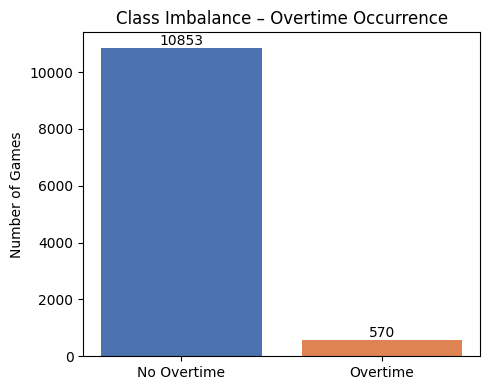

In [23]:
features = [
    "elo_diff",
    "home_avg_points",
    "away_avg_points",
    "home_last_5_win_percentage",
    "away_last_5_win_percentage",
    "home_season_win_percentage",
    "away_season_win_percentage",
    "home_off_eff_L10",
    "away_off_eff_L10",
    "home_def_efficiency",
    "away_def_efficiency",
    "home_pace_avg",
    "away_pace_avg",
    "pace_sum",
    "home_pts_std_L10",
    "away_pts_std_L10",
    "expected_total_pre",
    "off_eff_differential",
    "def_eff_differential",
    "eFG_differential",
    "rest_diff",
    "home_back_to_back",
    "away_back_to_back",
]

for col in features:
    df[col] = df[col].fillna(df[col].median())

df["overtime"] = df["overtime"].astype(int)

print("Overtime rate:", df["overtime"].mean())

X = df[features]
y = df["overtime"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = CatBoostClassifier(
    iterations=800,
    depth=6,
    learning_rate=0.03,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=[1, 15],
    random_seed=42,
    verbose=200
)

model.fit(X_train, y_train, eval_set=(X_test, y_test))

train_raw = model.predict(X_train, prediction_type="RawFormulaVal")
test_raw  = model.predict(X_test,  prediction_type="RawFormulaVal")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("F1:", f1_score(y_test, y_pred))

train_raw = np.array(train_raw).reshape(-1, 1)
test_raw  = np.array(test_raw).reshape(-1, 1)

calibrator = LogisticRegression(max_iter=500)
calibrator.fit(train_raw, y_train)

y_prob = calibrator.predict_proba(test_raw)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

print("\nMetrics AFTER REAL calibration:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("F1:", f1_score(y_test, y_pred))

counts = df["overtime"].value_counts().sort_index()

labels = ["No Overtime", "Overtime"]
values = counts.values
colors = ["#4C72B0", "#DD8452"] 

plt.figure(figsize=(5, 4))
plt.bar(labels, values, color=colors)

plt.title("Class Imbalance – Overtime Occurrence")
plt.ylabel("Number of Games")

for i, v in enumerate(values):
    plt.text(i, v, f"{v}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [ ]:
base_dir = os.path.dirname(os.getcwd())
models_dir = os.path.join(base_dir, "models")
scalers_dir = os.path.join(base_dir, 'scalers')

MODEL_PATH = os.path.join(models_dir, "overtime_model_gb.pkl")
SCALER_PATH = os.path.join(scalers_dir, "overtime_scaler.pkl")

joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)